In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
from dataset import PSFDataset, ToTensor, Normalize
from net import Net
from collections import OrderedDict
import numpy as np

import os
import logging
import argparse
import utils

In [2]:
if __name__ == '__main__':

    model_dir = 'models/'
    data_dir = 'psfs/'
    model_version = 'models/baseline/lr0.001_b4_e10/'

    # Load params
    json_path = os.path.join(model_version, 'params.json')
    assert os.path.isfile(json_path), logging.error("No json configuration file found at {}".format(json_path))
    params = utils.Params(json_path)

    # Load dataset
    dataset = PSFDataset(root_dir=data_dir, size=params.dataset_size//10,
                         transform=transforms.Compose([Normalize(), ToTensor()]))
    
    # Ensure reproducability
    random_seed= 42
    shuffle_dataset = True
    
    # Split train-test
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(params.dev_split[1] * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]
    
    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    
    train_dataloader = DataLoader(dataset, batch_size=1, num_workers=4, sampler=train_sampler)
    val_dataloader = DataLoader(dataset, batch_size=1, num_workers=4, sampler=val_sampler)

In [3]:
    # Load convolutional network
    net = Net() 
    state_dict = torch.load(os.path.join(model_version, 'checkpoint.pth'), map_location=torch.device('cpu'))
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] # remove module.
        new_state_dict[name] = v
        
    # Convert to CPU 
    net.load_state_dict(new_state_dict)
    
    # Loss function
    criterion = nn.MSELoss()
    
    # Optimizer
    optimizer = optim.Adam(net.parameters(), lr=params.learning_rate)

In [4]:
    # Validation 
    net.eval()
    val_loss = 0.0
    for i_batch, sample_batched in enumerate(val_dataloader):
        zernike = sample_batched['zernike']
        image = sample_batched['image']

        outputs = net(image)
        loss = criterion(outputs, zernike)
        val_loss += float(loss)

    print('Validation loss: %.3f ' % (val_loss / len(val_dataloader)))

Validation loss: 752.236 


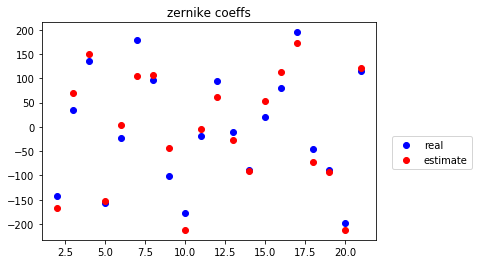

[Zernike 2 ] Estimated: -167.813 | Real: -142.176 | Error: 18.03 %
[Zernike 3 ] Estimated: 69.433   | Real: 34.130   | Error: 103.44 %
[Zernike 4 ] Estimated: 149.205  | Real: 135.771  | Error: 9.89 %
[Zernike 5 ] Estimated: -152.884 | Real: -155.913 | Error: 1.94 %
[Zernike 6 ] Estimated: 3.396    | Real: -23.798  | Error: 114.27 %
[Zernike 7 ] Estimated: 104.409  | Real: 178.322  | Error: 41.45 %
[Zernike 8 ] Estimated: 106.064  | Real: 96.273   | Error: 10.17 %
[Zernike 9 ] Estimated: -42.702  | Real: -102.143 | Error: 58.19 %
[Zernike 10] Estimated: -212.227 | Real: -177.040 | Error: 19.88 %
[Zernike 11] Estimated: -4.756   | Real: -19.191  | Error: 75.22 %
[Zernike 12] Estimated: 60.915   | Real: 94.147   | Error: 35.30 %
[Zernike 13] Estimated: -27.456  | Real: -10.474  | Error: 162.13 %
[Zernike 14] Estimated: -91.517  | Real: -88.031  | Error: 3.96 %
[Zernike 15] Estimated: 53.636   | Real: 19.940   | Error: 168.99 %
[Zernike 16] Estimated: 113.954  | Real: 80.053   | Error: 42

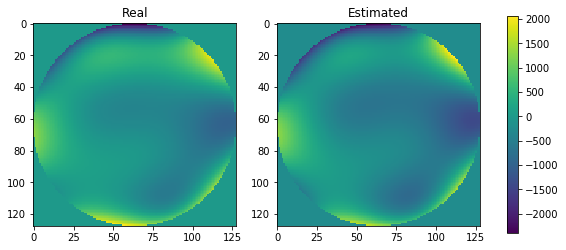

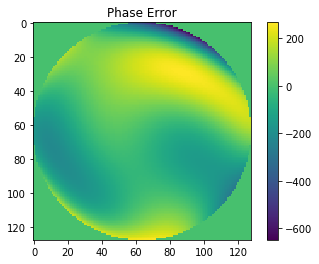

In [6]:
    # Visualization: zernike coefficients and estimate 
    import numpy as np
    import matplotlib.pyplot as plt
    import aotools
    
    sample = dataset[0]
    zernike = sample['zernike'].unsqueeze(0)
    image = sample['image'].unsqueeze(0)
    outputs = net(image)
    loss = criterion(outputs, zernike)
    outputs = outputs.detach().numpy()
    zernike = zernike.detach().numpy()
    x = np.arange(20) + 2
    plt.plot(x, np.transpose(zernike), 'ro', color='blue', label='real')
    plt.plot(x, np.transpose(outputs), 'ro', label='estimate')
    plt.legend(bbox_to_anchor=(1.3, 0.5))
    plt.title('zernike coeffs')
    plt.show()
    
    id = 0
    total_error = 0.0
    for i in np.nditer(zernike):
        estimate = "%.3f" % outputs[0,id]
        real = "%.3f" % i
        error = i - outputs[0,id]
        relative_error = 100*np.abs(error/i)
        total_error += relative_error
        print("[Zernike %-*s] Estimated: %-*s | Real: %-*s | Error: %0.2f %%" % (2, str(id+2), 8, estimate, 8, real, relative_error))
        id += 1
    print("Average error per coeff: %0.2f %%" % (total_error/20.))    
    print('RMS Loss: %0.3f'% (loss))
        
    # Generate the Zernike modal basis
    nbOfZernike = 20
    Zs = aotools.zernikeArray(nbOfZernike + 1, 128, norm='rms')  
    real_phase = np.squeeze(np.sum(zernike[0, :, None, None] * Zs[1:, :, :], axis=0))
    estimated_phase = np.squeeze(np.sum(outputs[0, :, None, None] * Zs[1:, :, :], axis=0))
    f, axarr = plt.subplots(1,2, figsize=(10, 10))
    im = axarr[0].imshow(real_phase)
    axarr[0].set_title("Real")
    axarr[1].imshow(estimated_phase)
    axarr[1].set_title("Estimated")
    f.colorbar(im, ax=axarr.ravel().tolist(), shrink=0.4)
    plt.show()
    phase_error = real_phase - estimated_phase
    plt.imshow(phase_error)
    plt.colorbar()
    plt.title('Phase Error')
    plt.show()

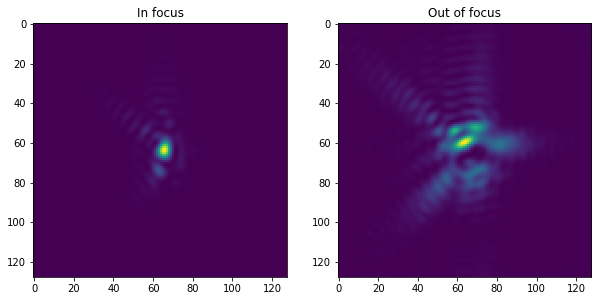

confParse.py -> calcParams: Overriding sci FOV with pxlscale


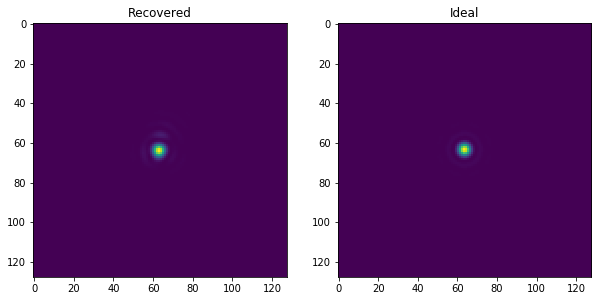

In [7]:
    from soapy import SCI, confParse
    
    image = sample['image'].detach().numpy()
    
    # Input images
    f, axarr = plt.subplots(1,2, figsize=(10, 10))
    im = axarr[0].imshow(image[0,:,:])
    axarr[0].set_title("In focus")
    axarr[1].imshow(image[1,:,:])
    axarr[1].set_title("Out of focus")
    plt.show()
    
    # Reconstruct unaberrated PSFs
    pixelScale = 0.01
    diameter = 10
    SOAPY_CONF = "config/psf.yaml"
    config = confParse.loadSoapyConfig(SOAPY_CONF)
    config.scis[0].pxlScale = pixelScale
    config.calcParams()
    config.tel.telDiam = diameter
    config.calcParams()
    mask = aotools.circle(config.sim.pupilSize/2., config.sim.simSize)
    psfObj = SCI.PSF(config, nSci=0, mask=mask)
    aberrations = np.zeros((128,128))
    unaberrated = np.copy(psfObj.frame(aberrations.astype(float)))
    recovered_psf = np.copy(psfObj.frame(np.squeeze(phase_error.astype(float))))
    
    # Recovered images
    f, axarr = plt.subplots(1,2, figsize=(10, 10))
    im = axarr[0].imshow(recovered_psf)
    axarr[0].set_title("Recovered")
    axarr[1].imshow(unaberrated)
    axarr[1].set_title("Ideal")
    plt.show()